In [1]:
import tensorflow as tf
from tensorflow.keras.datasets.reuters import load_data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
import os
from gensim import models
import gensim.downloader
from tqdm import tqdm

In [2]:
SEED = 12345
tf.random.set_seed(SEED)

In [3]:
# glove embedding
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [4]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative100.bin.gz"

## Data

### Loading

In [5]:
(X, y), (_, _) = load_data(test_split=0.0)

2113536/2110848 [==============================] - 0s 0us/step


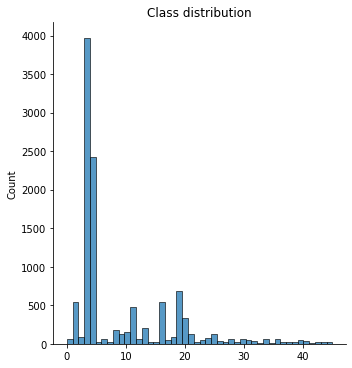

In [6]:
sns.displot(y)
plt.title('Class distribution')
plt.show()

### Top frequent classes

Due to data inbalance we take only top 10 most frequent classes.

In [7]:
unique, counts = np.unique(y, return_counts=True)
classes = dict(zip(unique, counts))
sorted_classes = [
  x[0] for x in sorted(classes.items(),
                       key=lambda item: item[1],
                       reverse=True)
  ]
top_10_classes = sorted_classes[0:10]

In [8]:
top_10_classes

[3, 4, 19, 16, 1, 11, 20, 13, 8, 10]

In [9]:
sorted(classes.items(),
  key=lambda item: item[1],
  reverse=True
)[0:10]

[(3, 3972),
 (4, 2423),
 (19, 682),
 (16, 543),
 (1, 537),
 (11, 473),
 (20, 339),
 (13, 209),
 (8, 177),
 (10, 154)]

In [10]:
recoded_dict = {}

i = 0
for c in top_10_classes:
  recoded_dict[c] = i
  i += 1

In [11]:
topics = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

classes_dict = {}
for c in top_10_classes:
  classes_dict[recoded_dict[c]] = topics[c]

classes_dict

{0: 'earn',
 1: 'acq',
 2: 'money-fx',
 3: 'crude',
 4: 'grain',
 5: 'trade',
 6: 'interest',
 7: 'ship',
 8: 'money-supply',
 9: 'sugar'}

### Data generator

Function to generate daset for N most frequent words.

In [12]:
def get_datasets(num_words, input_size):

  (X, y), (_, _) = load_data(num_words=num_words, test_split=0.0)

  X = X[np.isin(y, top_10_classes)]
  y = y[np.isin(y, top_10_classes)]
  
  y = np.array([recoded_dict[k] for k in y])

  #padding
  X = np.array([
    np.pad(
        x, (input_size-len(x), 0)
    ) if input_size > len(x) else np.array(x[0:input_size]) for x in X
  ])
  # X = tf.convert_to_tensor(X)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.4, random_state=SEED
  )
  X_val, X_test, y_val, y_test = train_test_split(
      X_test, y_test, test_size=0.5, random_state=SEED
  )

  train_data = {
      'X': X_train,
      'y': y_train
  }
  val_data = {
      'X': X_val,
      'y': y_val
  }
  test_data = {
      'X': X_test,
      'y': y_test
  }

  return train_data, val_data, test_data

In [13]:
a = np.array([1,2,3])

In [14]:
np.pad(a, (2, 0))

array([0, 0, 1, 2, 3])

## Helper functions

In [15]:
def print_results(model):
  print('--------MODEL--------')
  print()
  print(model.name)
  # print()
  # print(model.model.summary())
  print()
  # print('Optimizer: ', model.params['optimizer'])
  # print('Learning rate: ', model.params['lr'])
  # print('Epochs: ', model.params['epochs'])
  # print('Batch: ', model.params['batch'])
  print('Num words: ', model.params['num_words'])
  print()
  print('Best validation Loss: ', max(model.history.history['val_loss']))
  print('Best validation Accuracy: ', max(model.history.history['val_accuracy']))
  print('Best validation F1Score: ', max(model.history.history['val_f1score']))
  print()


def plot_history(history):
  history = history.history

  epochs = [i+1 for i in range(len(history['loss']))]
  fig, axs = plt.subplots(1, 3, figsize=(20,5))
  axs[0].plot(epochs, history['loss'], label='TRAIN')
  axs[0].plot(epochs, history['val_loss'], label='VALIDATION')
  axs[0].legend()
  axs[0].title.set_text('LOSS')
  axs[0].set_xlabel('EPOCH')
  axs[0].set_ylabel('VALUE')
  axs[1].plot(epochs, history['f1score'], label='TRAIN')
  axs[1].plot(epochs, history['val_f1score'], label='VALIDATION')
  axs[1].legend()
  axs[1].title.set_text('F1 SCORE')
  axs[1].set_xlabel('EPOCH')
  axs[1].set_ylabel('VALUE')
  axs[2].plot(epochs, history['accuracy'], label='TRAIN')
  axs[2].plot(epochs, history['val_accuracy'], label='VALIDATION')
  axs[2].legend()
  axs[2].title.set_text('ACCURACY')
  axs[2].set_xlabel('EPOCH')
  axs[2].set_ylabel('VALUE')
  plt.show()
  

def show_results(model):
  print_results(model)
  plot_history(model.history)
  print()


def get_misclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] != y_pred.numpy()[i] and y_true.numpy()[i] == c]


def get_properclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] == y_pred.numpy()[i] and y_true.numpy()[i] == c]


def plot_misclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_misclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_misclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_misclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[2]].numpy()])
    plt.show()
    

def plot_properclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_properclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_properclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_properclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[2]].numpy()])
    plt.show()

def test_model(model):

    show_results(model)

    model = model.model

    print()
    y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
    y_pred_probs = model.predict(test_ds['X'])
    print('Test F1: '+str(f1score(y_true, y_pred_probs)))

    print()
    print(metrics_summary(y_true, y_pred_probs))

    print()

    y_pred = tf.math.argmax(y_pred_probs, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])

    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(matrix, index = labels,
                      columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()


## Custom metrics

In [16]:
def f1score(y_true, y_pred):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    return f1_score(y_true, y_pred, average='macro')

def metrics_summary(y_true, y_pred):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    return classification_report(y_true, y_pred, target_names=classes_dict.values())    

## Custom layers


### Embedding

In [17]:
words_dict = {y:x for x,y in tf.keras.datasets.reuters.get_word_index().items()}  

557056/550378 [==============================] - 0s 0us/step


In [18]:
glove_embeddings = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [19]:
w2v_embeddings = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [20]:
fasttext_embeddings = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [21]:
class Embedding(tf.keras.layers.Layer):

  def __init__(self, num_words, embedding):

    super(Embedding, self).__init__()

    if embedding == 'glove':
      emb_model = glove_embeddings
    elif embedding == 'w2v':
      emb_model = w2v_embeddings
    elif embedding == 'fasttext':
      emb_model = fasttext_embeddings
    else:
      raise Exception('Wrong embedding name!')

    emb_matrix = []

    print()
    print('Preparing embeddings...')

    for i in range(3):
      emb_matrix.append(list(np.random.normal(size=300)))

    for i in tqdm(range(3, num_words)):
      try:
        word = words_dict[i]
        emb_matrix.append(list(emb_model[word]))
      except Exception as e:
        print(e)
        emb_matrix.append(list(np.random.normal(size=300)))

    self.emb_matrix = self.add_weight(
      shape=(num_words, 300),
      initializer=tf.keras.initializers.Constant(
          tf.convert_to_tensor(
              np.array(emb_matrix),
              dtype=tf.float32
          )
      ),
      trainable=False
    )

  def __call__(self, words_ids):

    return tf.nn.embedding_lookup(self.emb_matrix, words_ids)

### RNN

In [22]:
class RNN2(tf.keras.layers.Layer):

  def __init__(self, state_size, input_size, output_size):

    super(RNN2, self).__init__()
    self.state_size = state_size
    self.input_size = input_size
    self.output_size = output_size

    self.W_pred = self.add_weight(
        shape=([self.state_size*2, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_pred = self.add_weight(
        shape=([self.output_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_h = self.add_weight(
        shape=([self.state_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.W_x = self.add_weight(
        shape=([self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b = self.add_weight(
        shape=([self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

  def call(self, x):

    x = tf.transpose(x, perm=[1, 0, 2])

    initial_state = tf.zeros(
      [x.shape[1], self.state_size],
      name='initial_state'
    )
    states1 = tf.scan(
      self._rnn_step, x,
      initializer=initial_state,
      name='states1'
    )
    states2 = tf.scan(
      self._rnn_step, tf.reverse(x, [2]),
      initializer=initial_state,
      name='states2'
    )

    states = tf.concat((states1, states2), 2)
    predictions = tf.add(
        tf.matmul(states, self.W_pred),
        self.b_pred,
        name='predictions'
    )
        
    return states, predictions

  def _rnn_step(self, h_prev, x):

    h = tf.tanh(
      tf.matmul(h_prev, self.W_h) + tf.matmul(x, self.W_x) + self.b
    )

    return h

### LSTM

In [23]:
class LSTM2(tf.keras.layers.Layer):

  def __init__(self, state_size, input_size, output_size):

    super(LSTM2, self).__init__()
    self.state_size = state_size
    self.input_size = input_size
    self.output_size = output_size

    self.W_f = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_f = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_i = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_i = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_C = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_C = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_o = self.add_weight(
        shape=([self.state_size + self.input_size, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_o = self.add_weight(
        shape=([1, self.state_size]),
        initializer='random_uniform',
        trainable=True
    )

    self.W_v = self.add_weight(
        shape=([self.state_size*2, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )
    self.b_v = self.add_weight(
        shape=([1, self.output_size]),
        initializer='random_uniform',
        trainable=True
    )

  def call(self, x):

    x = tf.transpose(x, perm=[1, 0, 2])

    initial_h_state = tf.zeros(
      [x.shape[1], self.state_size]
    )
    initial_C_state = tf.zeros(
      [x.shape[1], self.state_size]
    )
    initial_state = (initial_h_state, initial_C_state)

    states1 = tf.scan(
      self._lstm_step, x,
      initializer=initial_state,
      name='states1'
    )
    states2 = tf.scan(
      self._lstm_step, tf.reverse(x, [2]),
      initializer=initial_state,
      name='states2'
    )

    h_states1 = states1[1]
    h_states2 = states2[1]
    h_states = tf.concat((h_states1, h_states2), 2)

    predictions = tf.add(
        tf.matmul(h_states, self.W_v),
        self.b_v,
        name='predictions'
    )
        
    return h_states, predictions

  def _lstm_step(self, prev_result, x):

    (C_state_prev, h_state_prev) = prev_result

    # forget gate

    f_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_f),
            self.b_f
        )
    )

    # input gate

    i_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_i),
            self.b_i
        )
    )

    cC_state = tf.tanh(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_C),
            self.b_C
        )
    )

    # update C state

    C_state = tf.add(
        f_t * C_state_prev,
        i_t * cC_state
    )

    # update h state

    o_t = tf.sigmoid(
        tf.add(
            tf.matmul(tf.concat((h_state_prev, x), axis = 1), self.W_o),
            self.b_o
        )
    )

    h_state = o_t * tf.tanh(C_state)

    return (C_state, h_state)

## Models

In [24]:
class RNNModel2(tf.keras.Model):

  def __init__(
      self,
      num_words,
      embedding,
      state_size,
      output_size):
    super(RNNModel2, self).__init__()
    self.embedding = Embedding(num_words, embedding)
    self.rnn = RNN2(state_size, 300, output_size)
    self.act = tf.keras.activations.softmax


  def call(self, inputs, training=False):
    X = self.embedding(inputs)
    X = self.rnn(X)[1][-1]
    X = self.act(X)

    return X


class LSTMModel2(tf.keras.Model):

  def __init__(
      self,
      num_words,
      embedding,
      state_size,
      output_size):
    super(LSTMModel2, self).__init__()
    self.embedding = Embedding(num_words, embedding)
    self.lstm = LSTM2(state_size, 300, output_size)
    self.act = tf.keras.activations.softmax


  def call(self, inputs, training=False):
    X = self.embedding(inputs)
    X = self.lstm(X)[1][-1]
    X = self.act(X)

    return X

In [25]:
class Model1:
  def __init__(
      self,
      num_words,
      embedding,
      state_size,
      output_size=10):

    self.model = RNNModel2(
      num_words=num_words,
      embedding=embedding,
      state_size=state_size,
      output_size=output_size
    )

    self.name = 'Model1_RNN2'
    self.history = None
    self.params = None
    self.test_ds = None

  
class Model2:
  def __init__(
      self,
      num_words,
      embedding,
      state_size,
      output_size=10):

    self.model = LSTMModel2(
      num_words=num_words,
      embedding=embedding,
      state_size=state_size,
      output_size=output_size
    )

    self.name = 'Model2_LSTM2'
    self.history = None
    self.params = None
    self.test_ds = None

## Training

In [26]:
params = {
    'model': [Model1, Model2],
    'num_words': [1000],
    'input_size': [100],
    'embedding': ['glove', 'w2v', 'fasttext'],
    'state_size': [64],
    'optimizer': ['adam'],
    'lr': [0.001],
    'epochs': [50],
    'batch': [500]
}

results = pd.DataFrame(columns=[
                                'model', 'num_words', 'input_size',
                                'embedding', 'state_size', 'optimizer',
                                'lr', 'epochs', 'batch',
                                'best_val_loss', 'best_val_acc', 'best_val_f1'
])
trained_models = []

keys = list(params)
for values in itertools.product(*map(params.get, keys)):
  params_dict = dict(zip(keys, values))

  tf.keras.backend.clear_session()

  if params_dict['optimizer'] == 'adam':
    opt = tf.keras.optimizers.Adam(params_dict['lr'])
  else: 
    opt = tf.keras.optimizers.SGD(params_dict['lr'])

  model = params_dict['model'](
      num_words=params_dict['num_words'],
      embedding=params_dict['embedding'],
      state_size=params_dict['state_size']
  )

  model.model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy', f1score], run_eagerly=True)
  
  train_ds, val_ds, test_ds = get_datasets(
      params_dict['num_words'],
      params_dict['input_size']
  )

  history = model.model.fit(train_ds['X'], train_ds['y'],
                      batch_size=params_dict['batch'],
                      epochs=params_dict['epochs'], 
                      validation_data=(val_ds['X'], val_ds['y']))

  model.test_ds = test_ds
  model.params = params_dict
  model.history = history
  trained_models.append(model)
  results = results.append({
      'model': model.name,
      'num_words': params_dict['num_words'],
      'input_size': params_dict['input_size'],
      'embedding': params_dict['embedding'],
      'state_size': params_dict['state_size'],
      'optimizer': params_dict['optimizer'],
      'lr': params_dict['lr'],
      'epochs': params_dict['epochs'],
      'batch': params_dict['batch'],
      'best_val_loss': max(history.history['val_loss']),
      'best_val_acc': max(history.history['val_accuracy']),
      'best_val_f1': max(history.history['val_f1score'])
  }, ignore_index=True)

results = results.reset_index(inplace=False)

100%|██████████| 997/997 [00:00<00:00, 35626.41it/s]


Preparing embeddings...
"word 'shrs' not in vocabulary"
"word 'mths' not in vocabulary"
"word 'company's' not in vocabulary"
"word 'qtly' not in vocabulary"
"word 'year's' not in vocabulary"
"word 'japan's' not in vocabulary"
"word 'bank's' not in vocabulary"
"word 'government's' not in vocabulary"
"word 'it's' not in vocabulary"
"word 'country's' not in vocabulary"
"word 'today's' not in vocabulary"
"word 'don't' not in vocabulary"


Epoch 1/50
12/12 [==============================] - 4s 295ms/step - loss: 1.8747 - accuracy: 0.4205 - f1score: 0.0833 - val_loss: 1.6746 - val_accuracy: 0.4190 - val_f1score: 0.0756
Epoch 2/50
12/12 [==============================] - 4s 299ms/step - loss: 1.6810 - accuracy: 0.4282 - f1score: 0.0842 - val_loss: 1.6407 - val_accuracy: 0.4274 - val_f1score: 0.0928
Epoch 3/50
12/12 [==============================] - 4s 300ms/step - loss: 1.6562 - accuracy: 0.4358 - f1score: 0.0942 - val_loss: 1.6358 - val_accuracy: 0.4364 - val_f1score: 0.0941
Epoch 4/50
12/12 [==============================] - 4s 294ms/step - loss: 1.6478 - accuracy: 0.4403 - f1score: 0.0952 - val_loss: 1.6235 - val_accuracy: 0.4380 - val_f1score: 0.0942
Epoch 5/50
12/12 [==============================] - 3s 289ms/step - loss: 1.6391 - accuracy: 0.4456 - f1score: 0.0952 - val_loss: 1.6180 - val_accuracy: 0.4411 - val_f1score: 0.0952
Epoch 6/50
12/12 [==============================] - 3s 273ms/step - loss: 1.6293 - accurac

100%|██████████| 997/997 [00:00<00:00, 21133.68it/s]


Preparing embeddings...
"word 'to' not in vocabulary"
"word 'and' not in vocabulary"
"word 'a' not in vocabulary"
"word 'reuter' not in vocabulary"
"word '000' not in vocabulary"
"word '1986' not in vocabulary"
"word '10' not in vocabulary"
"word '1987' not in vocabulary"
"word '15' not in vocabulary"
"word '1985' not in vocabulary"
"word '20' not in vocabulary"
"word '30' not in vocabulary"
"word '50' not in vocabulary"
"word '12' not in vocabulary"
"word '25' not in vocabulary"
"word '31' not in vocabulary"
"word '16' not in vocabulary"
"word '11' not in vocabulary"
"word '13' not in vocabulary"
"word '14' not in vocabulary"
"word '17' not in vocabulary"
"word '87' not in vocabulary"
"word '18' not in vocabulary"
"word '100' not in vocabulary"
"word '19' not in vocabulary"
"word '22' not in vocabulary"
"word '40' not in vocabulary"
"word '28' not in vocabulary"
"word '24' not in vocabulary"
"word '500' not in vocabulary"
"word '27' not in vocabulary"
"word '23' not in vocabulary"
"w

Epoch 1/50
12/12 [==============================] - 3s 275ms/step - loss: 2.0009 - accuracy: 0.3872 - f1score: 0.0916 - val_loss: 1.7280 - val_accuracy: 0.4206 - val_f1score: 0.0820
Epoch 2/50
12/12 [==============================] - 3s 270ms/step - loss: 1.7005 - accuracy: 0.4270 - f1score: 0.0850 - val_loss: 1.6647 - val_accuracy: 0.4369 - val_f1score: 0.0951
Epoch 3/50
12/12 [==============================] - 4s 292ms/step - loss: 1.6668 - accuracy: 0.4415 - f1score: 0.0937 - val_loss: 1.6351 - val_accuracy: 0.4369 - val_f1score: 0.0895
Epoch 4/50
12/12 [==============================] - 3s 277ms/step - loss: 1.6459 - accuracy: 0.4407 - f1score: 0.0912 - val_loss: 1.6224 - val_accuracy: 0.4401 - val_f1score: 0.0921
Epoch 5/50
12/12 [==============================] - 3s 289ms/step - loss: 1.6268 - accuracy: 0.4479 - f1score: 0.0960 - val_loss: 1.5821 - val_accuracy: 0.4453 - val_f1score: 0.0990
Epoch 6/50
12/12 [==============================] - 4s 293ms/step - loss: 1.6040 - accurac

100%|██████████| 997/997 [00:00<00:00, 42082.33it/s]


Preparing embeddings...
"word 'reuter' not in vocabulary"
"word 'shrs' not in vocabulary"
"word 'company's' not in vocabulary"
"word 'qtly' not in vocabulary"
"word 'year's' not in vocabulary"
"word 'japan's' not in vocabulary"
"word 'bundesbank' not in vocabulary"
"word 'bank's' not in vocabulary"
"word 'government's' not in vocabulary"
"word 'it's' not in vocabulary"
"word 'country's' not in vocabulary"
"word 'gatt' not in vocabulary"
"word 'today's' not in vocabulary"
"word 'don't' not in vocabulary"
"word 'usair' not in vocabulary"


Epoch 1/50
12/12 [==============================] - 4s 295ms/step - loss: 2.1952 - accuracy: 0.3656 - f1score: 0.0733 - val_loss: 2.0135 - val_accuracy: 0.4122 - val_f1score: 0.0656
Epoch 2/50
12/12 [==============================] - 3s 274ms/step - loss: 1.8307 - accuracy: 0.4196 - f1score: 0.0695 - val_loss: 1.6830 - val_accuracy: 0.4180 - val_f1score: 0.0737
Epoch 3/50
12/12 [==============================] - 3s 267ms/step - loss: 1.6877 - accuracy: 0.4258 - f1score: 0.0816 - val_loss: 1.6362 - val_accuracy: 0.4332 - val_f1score: 0.0854
Epoch 4/50
12/12 [==============================] - 3s 274ms/step - loss: 1.6085 - accuracy: 0.4407 - f1score: 0.0909 - val_loss: 1.4902 - val_accuracy: 0.5126 - val_f1score: 0.1217
Epoch 5/50
12/12 [==============================] - 3s 271ms/step - loss: 1.5483 - accuracy: 0.4770 - f1score: 0.1165 - val_loss: 1.5421 - val_accuracy: 0.4632 - val_f1score: 0.1087
Epoch 6/50
12/12 [==============================] - 3s 271ms/step - loss: 1.5361 - accurac

100%|██████████| 997/997 [00:00<00:00, 49093.91it/s]


Preparing embeddings...
"word 'shrs' not in vocabulary"
"word 'mths' not in vocabulary"
"word 'company's' not in vocabulary"
"word 'qtly' not in vocabulary"
"word 'year's' not in vocabulary"
"word 'japan's' not in vocabulary"
"word 'bank's' not in vocabulary"
"word 'government's' not in vocabulary"
"word 'it's' not in vocabulary"
"word 'country's' not in vocabulary"
"word 'today's' not in vocabulary"
"word 'don't' not in vocabulary"


Epoch 1/50
12/12 [==============================] - 7s 616ms/step - loss: 2.0673 - accuracy: 0.4011 - f1score: 0.0837 - val_loss: 1.7283 - val_accuracy: 0.4269 - val_f1score: 0.0795
Epoch 2/50
12/12 [==============================] - 7s 617ms/step - loss: 1.6862 - accuracy: 0.4298 - f1score: 0.0820 - val_loss: 1.6319 - val_accuracy: 0.4416 - val_f1score: 0.0946
Epoch 3/50
12/12 [==============================] - 8s 655ms/step - loss: 1.6478 - accuracy: 0.4466 - f1score: 0.0951 - val_loss: 1.6185 - val_accuracy: 0.4422 - val_f1score: 0.0940
Epoch 4/50
12/12 [==============================] - 8s 670ms/step - loss: 1.6190 - accuracy: 0.4542 - f1score: 0.0972 - val_loss: 1.5636 - val_accuracy: 0.4648 - val_f1score: 0.1042
Epoch 5/50
12/12 [==============================] - 7s 624ms/step - loss: 1.5292 - accuracy: 0.5018 - f1score: 0.1149 - val_loss: 1.6473 - val_accuracy: 0.4416 - val_f1score: 0.0850
Epoch 6/50
12/12 [==============================] - 8s 645ms/step - loss: 1.5475 - accurac

100%|██████████| 997/997 [00:00<00:00, 22240.71it/s]


Preparing embeddings...
"word 'to' not in vocabulary"
"word 'and' not in vocabulary"
"word 'a' not in vocabulary"
"word 'reuter' not in vocabulary"
"word '000' not in vocabulary"
"word '1986' not in vocabulary"
"word '10' not in vocabulary"
"word '1987' not in vocabulary"
"word '15' not in vocabulary"
"word '1985' not in vocabulary"
"word '20' not in vocabulary"
"word '30' not in vocabulary"
"word '50' not in vocabulary"
"word '12' not in vocabulary"
"word '25' not in vocabulary"
"word '31' not in vocabulary"
"word '16' not in vocabulary"
"word '11' not in vocabulary"
"word '13' not in vocabulary"
"word '14' not in vocabulary"
"word '17' not in vocabulary"
"word '87' not in vocabulary"
"word '18' not in vocabulary"
"word '100' not in vocabulary"
"word '19' not in vocabulary"
"word '22' not in vocabulary"
"word '40' not in vocabulary"
"word '28' not in vocabulary"
"word '24' not in vocabulary"
"word '500' not in vocabulary"
"word '27' not in vocabulary"
"word '23' not in vocabulary"
"w

Epoch 1/50
12/12 [==============================] - 7s 623ms/step - loss: 2.1535 - accuracy: 0.3613 - f1score: 0.0937 - val_loss: 1.8719 - val_accuracy: 0.4280 - val_f1score: 0.0955
Epoch 2/50
12/12 [==============================] - 8s 659ms/step - loss: 1.7524 - accuracy: 0.4265 - f1score: 0.0874 - val_loss: 1.6460 - val_accuracy: 0.4280 - val_f1score: 0.0855
Epoch 3/50
12/12 [==============================] - 8s 642ms/step - loss: 1.6459 - accuracy: 0.4400 - f1score: 0.0922 - val_loss: 1.6072 - val_accuracy: 0.4474 - val_f1score: 0.0968
Epoch 4/50
12/12 [==============================] - 8s 654ms/step - loss: 1.5980 - accuracy: 0.4635 - f1score: 0.1022 - val_loss: 1.5120 - val_accuracy: 0.5042 - val_f1score: 0.1175
Epoch 5/50
12/12 [==============================] - 8s 648ms/step - loss: 1.4908 - accuracy: 0.5323 - f1score: 0.1262 - val_loss: 1.4101 - val_accuracy: 0.5647 - val_f1score: 0.1368
Epoch 6/50
12/12 [==============================] - 7s 616ms/step - loss: 1.3931 - accurac

100%|██████████| 997/997 [00:00<00:00, 44981.19it/s]


Preparing embeddings...
"word 'reuter' not in vocabulary"
"word 'shrs' not in vocabulary"
"word 'company's' not in vocabulary"
"word 'qtly' not in vocabulary"
"word 'year's' not in vocabulary"
"word 'japan's' not in vocabulary"
"word 'bundesbank' not in vocabulary"
"word 'bank's' not in vocabulary"
"word 'government's' not in vocabulary"
"word 'it's' not in vocabulary"
"word 'country's' not in vocabulary"
"word 'gatt' not in vocabulary"
"word 'today's' not in vocabulary"
"word 'don't' not in vocabulary"
"word 'usair' not in vocabulary"


Epoch 1/50
12/12 [==============================] - 8s 629ms/step - loss: 2.2091 - accuracy: 0.3995 - f1score: 0.0856 - val_loss: 2.0684 - val_accuracy: 0.4380 - val_f1score: 0.0887
Epoch 2/50
12/12 [==============================] - 8s 650ms/step - loss: 1.9535 - accuracy: 0.4312 - f1score: 0.0795 - val_loss: 1.7545 - val_accuracy: 0.4185 - val_f1score: 0.0737
Epoch 3/50
12/12 [==============================] - 7s 623ms/step - loss: 1.7148 - accuracy: 0.4261 - f1score: 0.0759 - val_loss: 1.6514 - val_accuracy: 0.4185 - val_f1score: 0.0737
Epoch 4/50
12/12 [==============================] - 8s 647ms/step - loss: 1.6577 - accuracy: 0.4309 - f1score: 0.0810 - val_loss: 1.5953 - val_accuracy: 0.4522 - val_f1score: 0.0952
Epoch 5/50
12/12 [==============================] - 8s 643ms/step - loss: 1.5567 - accuracy: 0.4771 - f1score: 0.1078 - val_loss: 1.4344 - val_accuracy: 0.5478 - val_f1score: 0.1288
Epoch 6/50
12/12 [==============================] - 8s 656ms/step - loss: 1.4015 - accurac

In [27]:
results.sort_values('best_val_f1', ascending=False)

,index,model,num_words,input_size,embedding,state_size,optimizer,lr,epochs,batch,best_val_loss,best_val_acc,best_val_f1
3,3,Model2_LSTM2,1000,100,glove,64,adam,0.001,50,500,1.728288,0.808097,0.579297
4,4,Model2_LSTM2,1000,100,w2v,64,adam,0.001,50,500,1.871908,0.689274,0.332197
5,5,Model2_LSTM2,1000,100,fasttext,64,adam,0.001,50,500,2.068383,0.604627,0.198437
0,0,Model1_RNN2,1000,100,glove,64,adam,0.001,50,500,1.784787,0.583070,0.194908
1,1,Model1_RNN2,1000,100,w2v,64,adam,0.001,50,500,1.728001,0.583596,0.159852
2,2,Model1_RNN2,1000,100,fasttext,64,adam,0.001,50,500,2.013472,0.547844,0.132336


--------MODEL--------

Model1_RNN2

Num words:  1000

Best validation Loss:  1.7847870588302612
Best validation Accuracy:  0.5830704569816589
Best validation F1Score:  0.19490835070610046



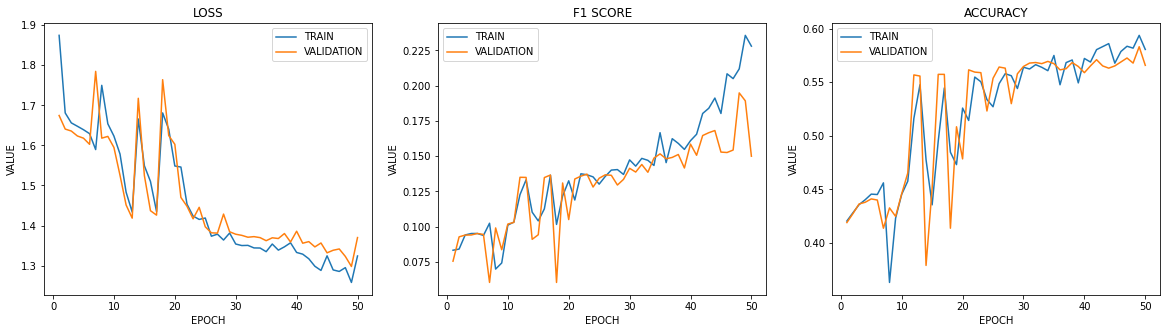


--------MODEL--------

Model1_RNN2

Num words:  1000

Best validation Loss:  1.7280011177062988
Best validation Accuracy:  0.5835962295532227
Best validation F1Score:  0.15985214710235596



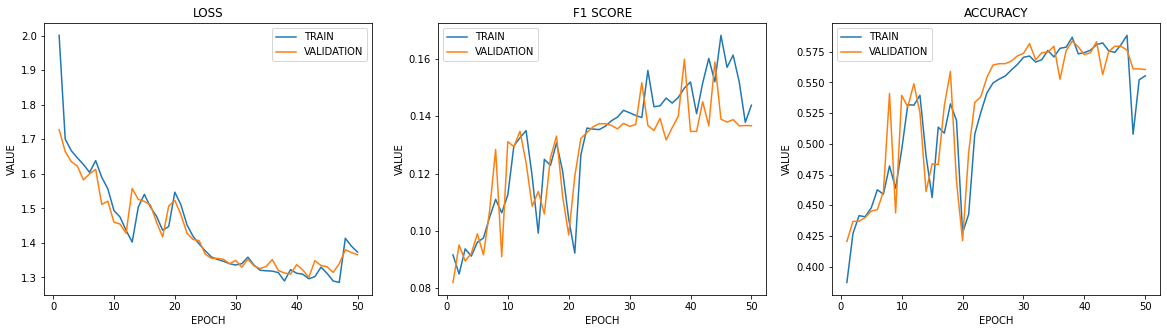


--------MODEL--------

Model1_RNN2

Num words:  1000

Best validation Loss:  2.0134716033935547
Best validation Accuracy:  0.5478443503379822
Best validation F1Score:  0.13233551383018494



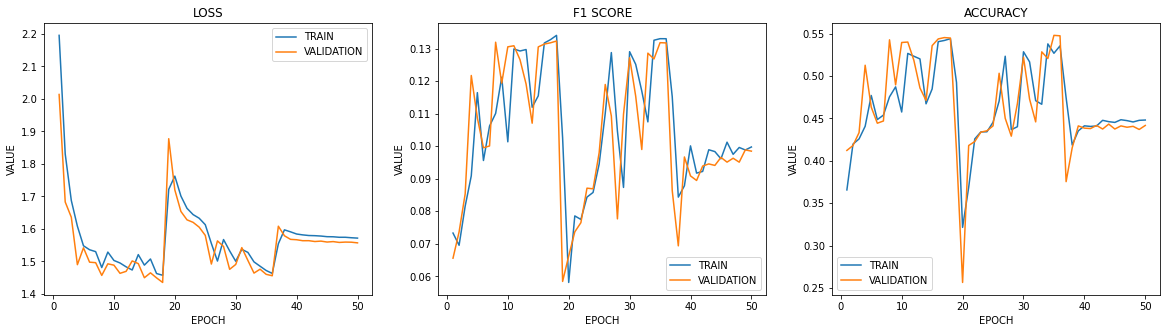


--------MODEL--------

Model2_LSTM2

Num words:  1000

Best validation Loss:  1.728287935256958
Best validation Accuracy:  0.8080967664718628
Best validation F1Score:  0.5792974233627319



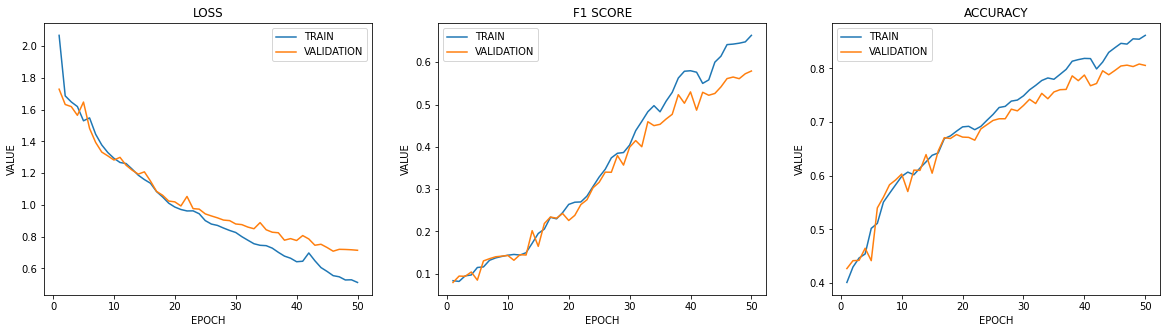


--------MODEL--------

Model2_LSTM2

Num words:  1000

Best validation Loss:  1.8719080686569214
Best validation Accuracy:  0.6892744302749634
Best validation F1Score:  0.33219659328460693



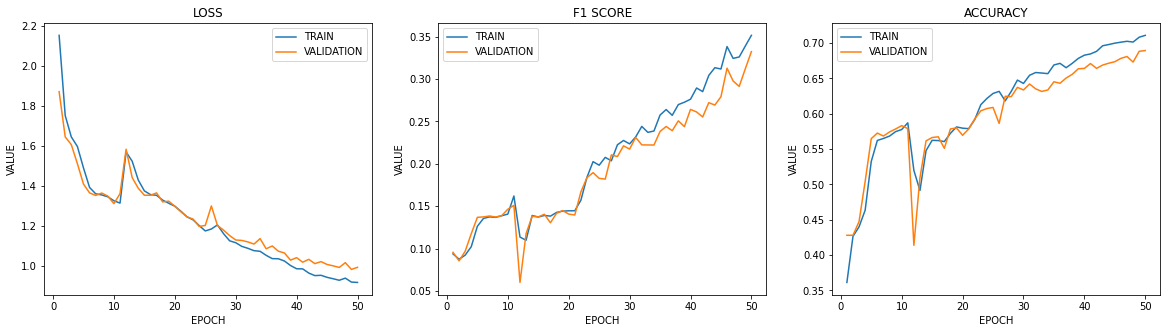


--------MODEL--------

Model2_LSTM2

Num words:  1000

Best validation Loss:  2.068382501602173
Best validation Accuracy:  0.6046267151832581
Best validation F1Score:  0.1984371691942215



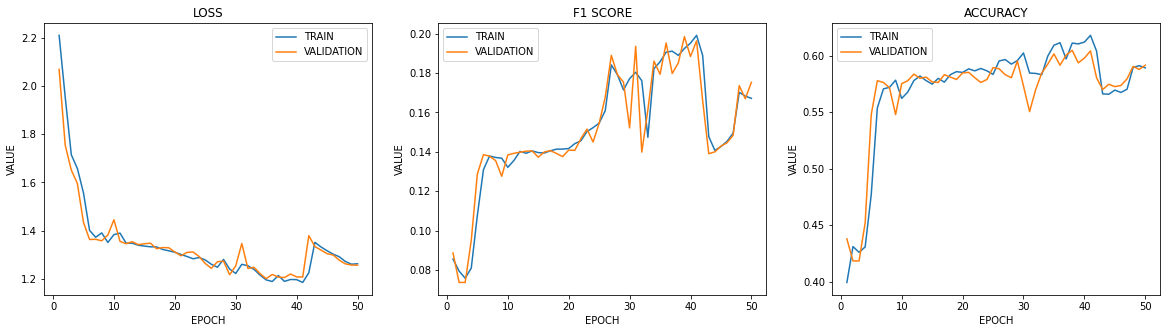

In [28]:
for model in trained_models:
  show_results(model)

## Best models

### Best RNN

In [29]:
model = trained_models[
  results[results['model'] == 'Model1_RNN2']
    .sort_values('best_val_f1', ascending=False)
    .iloc[0]['index']
  ]

--------MODEL--------

Model1_RNN2

Num words:  1000

Best validation Loss:  1.7847870588302612
Best validation Accuracy:  0.5830704569816589
Best validation F1Score:  0.19490835070610046



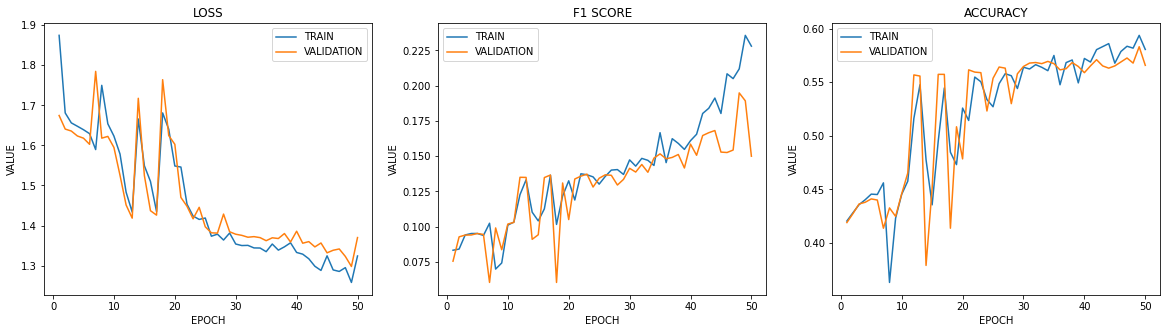

In [30]:
show_results(model)

In [31]:
model = model.model

In [32]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model.predict(test_ds['X'])
print('Test F1: '+str(f1score(y_true, y_pred_probs)))

Test F1: 0.14701201589143126


In [33]:
print(metrics_summary(y_true, y_pred_probs))

              precision    recall  f1-score   support

        earn       0.81      0.83      0.82       811
         acq       0.39      0.88      0.54       460
    money-fx       0.22      0.01      0.03       139
       crude       0.23      0.03      0.05       119
       grain       0.00      0.00      0.00        98
       trade       0.11      0.02      0.04        92
    interest       0.00      0.00      0.00        72
        ship       0.00      0.00      0.00        43
money-supply       0.00      0.00      0.00        40
       sugar       0.00      0.00      0.00        28

    accuracy                           0.57      1902
   macro avg       0.18      0.18      0.15      1902
weighted avg       0.48      0.57      0.49      1902



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


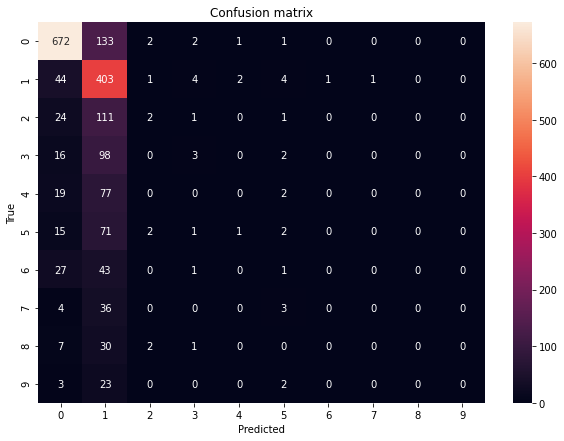

In [34]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### Best LSTM

In [35]:
model = trained_models[
  results[results['model'] == 'Model2_LSTM2']
    .sort_values('best_val_f1', ascending=False)
    .iloc[0]['index']
  ]

--------MODEL--------

Model2_LSTM2

Num words:  1000

Best validation Loss:  1.728287935256958
Best validation Accuracy:  0.8080967664718628
Best validation F1Score:  0.5792974233627319



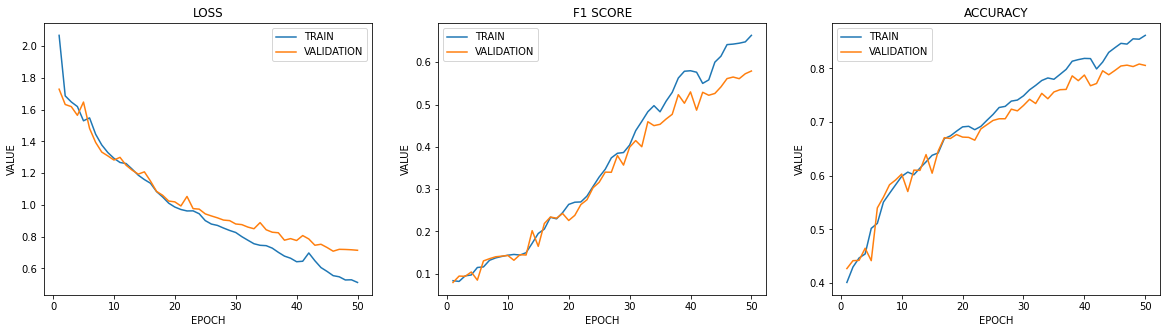

In [36]:
show_results(model)

In [37]:
model = model.model

In [38]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model.predict(test_ds['X'])
print('Test F1: '+str(f1score(y_true, y_pred_probs)))

Test F1: 0.5947064240235601


In [39]:
print(metrics_summary(y_true, y_pred_probs))

              precision    recall  f1-score   support

        earn       0.95      0.91      0.93       811
         acq       0.82      0.89      0.85       460
    money-fx       0.64      0.78      0.70       139
       crude       0.59      0.61      0.60       119
       grain       0.68      0.72      0.70        98
       trade       0.66      0.77      0.71        92
    interest       0.60      0.33      0.43        72
        ship       0.33      0.47      0.39        43
money-supply       0.61      0.42      0.50        40
       sugar       0.67      0.07      0.13        28

    accuracy                           0.81      1902
   macro avg       0.66      0.60      0.59      1902
weighted avg       0.81      0.81      0.80      1902



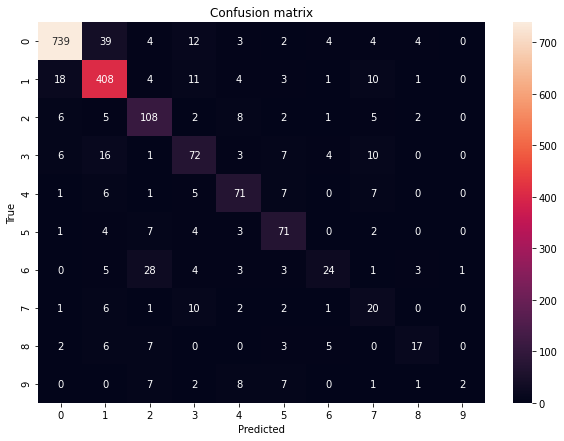

In [40]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()